In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random dataset

In [7]:
def random_bool(size):
    return np.random.rand(size) > 0.5

def random_int(min, max, size):
    return np.random.randint(min, max, size=size)

def random_float(min, max, size):
    return np.random.uniform(min, max, size=size)

def index_id(max):
    list = []
    for i in range(1, max):
        list.append('ID' + str(i))
    return list

In [8]:
pre_op = pd.DataFrame({'IDno': index_id(501), 'Død inden for 1 år af operation': random_bool(500), 'age': random_int(18, 89, 500), 'sex': random_bool(500), 'Respiratory Disease': random_bool(500),
       'Circulatory Organ Disease': random_bool(500), 'Type 1 Diabetes': random_bool(500), 'Type 2 Diabetes': random_bool(500),
       'Other metabolic diseases': random_bool(500), 'Other operation': random_bool(500), 'Genital or urine related diseases': random_bool(500), 'Vægt': random_float(35, 190,500), 'KFN': random_bool(500), 'KFX': random_bool(500), 'KFK': random_bool(500), 'KFM': random_bool(500),
       'KFF': random_bool(500), 'KFP': random_bool(500), 'KFC': random_bool(500), 'KFW': random_bool(500), 'KFJ': random_bool(500), 'Hæmoglobin': random_float(4,12,500), 'Leukocytter': random_float(1, 125, 500),
       'Trombocytter': random_float(20, 1000, 500)})
pre_op = pre_op.replace(True, 1).replace(False, 0)

/var/folders/7x/nmv5t4fj6z51p0khdp74mzf00000gn/T/ipykernel_55288/3656397265.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pre_op = pre_op.replace(True, 1).replace(False, 0)


# Predicting Mortality with pre_op data

## Logistic regression LR

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#TODO other params?
def lr_pred(X_train, y_train, X_test):
    lr = LogisticRegression()
    lr_grid = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
            'C': [100, 10, 1.0, 0.1, 0.01],
                'max_iter': [200,300]}
    
    grid_result = GridSearchCV(estimator = lr, param_grid = lr_grid, scoring='precision', cv=5)
    grid_result.fit(X_train,y_train)
    
    best_model = grid_result.best_estimator_ 

    lr_preds = best_model.predict_proba(X_test)[:,1]
    return lr_preds

    #TODO Take Best result of the fit or can i just return the predict 

## Random forest (RF)

In [79]:
from sklearn.ensemble import RandomForestClassifier

def rf_pred(X_train, y_train, X_test):
    rf = RandomForestClassifier()

    rf_grid = {'max_depth': [80, 90, 100, 110],
    'max_features': [2,5,10,15,22],
    'n_estimators': [100, 200, 300, 1000]}
    
    grid_result = GridSearchCV(estimator = rf, param_grid = rf_grid, scoring='precision', cv=5)
    grid_result.fit(X_train,y_train)
    
    best_model = grid_result.best_estimator_ 

    rf_preds = best_model.predict_proba(X_test)[:,1]
    return rf_preds

## Gradient boost


## MLP

# Grouped cross-validation

In [62]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold

X = pre_op.loc[:, pre_op.columns != 'Død inden for 1 år af operation']
X = X.loc[:, X.columns != 'IDno']
y = pre_op['Død inden for 1 år af operation']

outer_cv = GroupKFold(n_splits = 5)
inner_cv = GroupKFold(n_splits = 5)

#TODO add gbm and mlp into this dictionary
results = {
    'lr': {'pr_auc': [], 'roc_auc': [], 'precision': [], 'recall': [], 'fpr': [], 'tpr': []},
    'rf': {'pr_auc': [], 'roc_auc': [], 'precision': [], 'recall': [], 'fpr': [], 'tpr': []}
}

def evaluate_model(pred_func, model_name):
    for outer_train_idx, outer_test_idx in outer_cv.split(X, y, groups = pre_op['IDno']):
        X_outer_train, y_outer_train = X.iloc[outer_train_idx], y.iloc[outer_train_idx]
        X_outer_test, y_outer_test = X.iloc[outer_test_idx], y.iloc[outer_test_idx]

        inner_cv = GroupKFold(n_splits=5)
        inner_pr_auc_scores = []
        inner_roc_auc_scores = []

        for inner_train_idx, inner_test_idx in inner_cv.split(X_outer_train, y_outer_train, groups=pre_op['IDno'].iloc[outer_train_idx]):
            X_inner_train, y_inner_train = X_outer_train.iloc[inner_train_idx], y_outer_train.iloc[inner_train_idx]
            X_inner_test, y_inner_test = X_outer_train.iloc[inner_test_idx], y_outer_train.iloc[inner_test_idx]
            #TODO Make the perfomance class that returns PR AUC, ROC AUC and PR and ROC

            y_pred_prob = pred_func(X_inner_train, y_inner_train, X_inner_test)
    
            precision, recall, _ = precision_recall_curve(y_inner_test, y_pred_prob)
            pr_auc = auc(recall, precision)
            inner_pr_auc_scores.append(pr_auc)

            fpr, tpr, _ = roc_curve(y_inner_test, y_pred_prob)
            roc_auc = roc_auc_score(y_inner_test, y_pred_prob)
            inner_roc_auc_scores.append(roc_auc)

        y_pred_prob = pred_func(X_outer_train, y_outer_train, X_outer_test)

        # Compute PR AUC
        precision, recall, _ = precision_recall_curve(y_outer_test, y_pred_prob)
        pr_auc = auc(recall, precision)
        results[model_name]['pr_auc'].append(pr_auc)

        # Compute ROC AUC
        fpr, tpr, _ = roc_curve(y_outer_test, y_pred_prob)
        roc_auc = roc_auc_score(y_outer_test, y_pred_prob)
        results[model_name]['roc_auc'].append(roc_auc)

        results[model_name]['precision'].append(precision)
        results[model_name]['recall'].append(recall)
        results[model_name]['fpr'].append(fpr)
        results[model_name]['tpr'].append(tpr)

# ROC AUC and PR AUC calculations

In [67]:
evaluate_model(lr_pred, 'lr')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [ ]:
evaluate_model(rf_pred, 'rf')

In [74]:
def plot_results(model_name):
    plt.figure(figsize=(14, 6))

    # Plot PR curves
    plt.subplot(1, 2, 1)
    for i in range(len(results[model_name]['precision'])):
        plt.plot(results[model_name]['recall'][i], results[model_name]['precision'][i], alpha=1, label=f'Outer fold {i+1}', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR curve for {model_name.upper()}')
    plt.legend()

    # Plot ROC curves
    plt.subplot(1, 2, 2)
    for i in range(len(results[model_name]['fpr'])):
        plt.plot(results[model_name]['fpr'][i], results[model_name]['tpr'][i], alpha=1, label=f'Outer fold {i+1}', linewidth=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {model_name.upper()}')
    plt.legend()

    plt.tight_layout()
    plt.show()

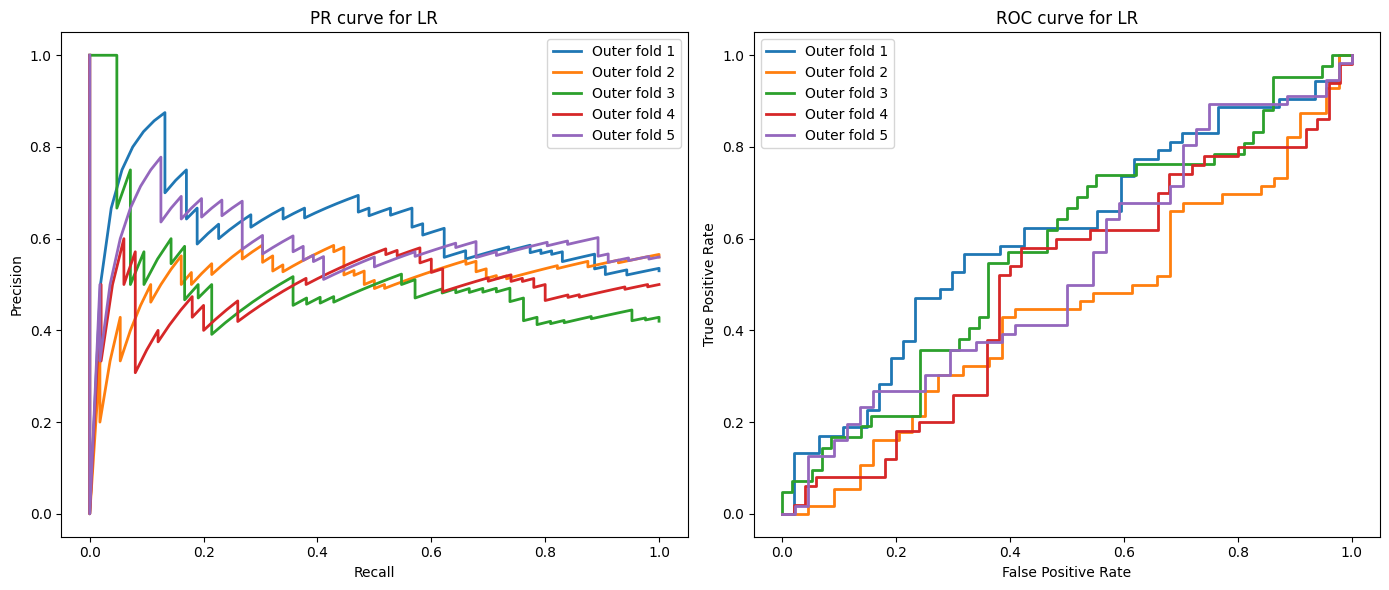

In [75]:
plot_results('lr')

In [56]:
def print_auc_values(model_name):
    print(f"Model: {model_name.upper()}")
    for i in range(len(results[model_name]['roc_auc'])):
        print(f"Fold {i+1} - ROC AUC: {results[model_name]['roc_auc'][i]:.4f}, PR AUC: {results[model_name]['pr_auc'][i]:.4f}")
    print(f"Average ROC AUC: {np.mean(results[model_name]['roc_auc']):.4f}")
    print(f"Average PR AUC: {np.mean(results[model_name]['pr_auc']):.4f}")
    print()

In [57]:
print_auc_values('lr')

Model: LR
Fold 1 - ROC AUC: 0.6114, PR AUC: 0.6207
Fold 2 - ROC AUC: 0.4464, PR AUC: 0.5163
Fold 3 - ROC AUC: 0.5727, PR AUC: 0.5030
Fold 4 - ROC AUC: 0.4964, PR AUC: 0.4853
Fold 5 - ROC AUC: 0.5300, PR AUC: 0.5839
Average ROC AUC: 0.5314
Average PR AUC: 0.5419

